In [35]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

from plotly import __version__
print(__version__) # need 1.9.0 or greater
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

4.9.0


## Загрузка и предобработка данных
Данные [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) по прогнозу популярности статьи на Хабрахабре.

In [36]:
habr_df = pd.read_csv('../data/howpop_train.csv')

In [37]:
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'url']]
habr_df = habr_df.drop_duplicates()

In [38]:
aggr_habr_df = habr_df.groupby('published')[['url']].count()
aggr_habr_df.columns = ['posts']

In [39]:
aggr_habr_df = aggr_habr_df.resample('D').apply(sum)
plotly_df(aggr_habr_df.resample('W').apply(sum), 
          title = 'Опубликованные посты на Хабрахабре')

## Построение прогноза Prophet

In [40]:
# pip install pystan
# pip install fbprophet
from fbprophet import Prophet

In [41]:
predictions = 30

df = aggr_habr_df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
3222,2016-10-27,58
3223,2016-10-28,53
3224,2016-10-29,14
3225,2016-10-30,27
3226,2016-10-31,80


In [42]:
train_df = df[:-predictions]

In [43]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30
3226,2016-10-31


In [45]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3222,2016-10-27,56.961139,54.023591,83.274382,56.961139,56.961139,10.737327,10.737327,10.737327,8.474006,8.474006,8.474006,2.263321,2.263321,2.263321,0.0,0.0,0.0,67.698466
3223,2016-10-28,56.958375,48.825326,78.371184,56.958373,56.958375,6.937116,6.937116,6.937116,4.653138,4.653138,4.653138,2.283978,2.283978,2.283978,0.0,0.0,0.0,63.895491
3224,2016-10-29,56.955610,21.243664,50.787419,56.954852,56.955610,-21.041173,-21.041173,-21.041173,-23.329790,-23.329790,-23.329790,2.288617,2.288617,2.288617,0.0,0.0,0.0,35.914437
3225,2016-10-30,56.952846,22.081721,52.805874,56.950224,56.952935,-18.612822,-18.612822,-18.612822,-20.890631,-20.890631,-20.890631,2.277809,2.277809,2.277809,0.0,0.0,0.0,38.340024
3226,2016-10-31,56.950082,54.398326,82.951286,56.946080,56.952576,11.839465,11.839465,11.839465,9.586986,9.586986,9.586986,2.252479,2.252479,2.252479,0.0,0.0,0.0,68.789548


In [46]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


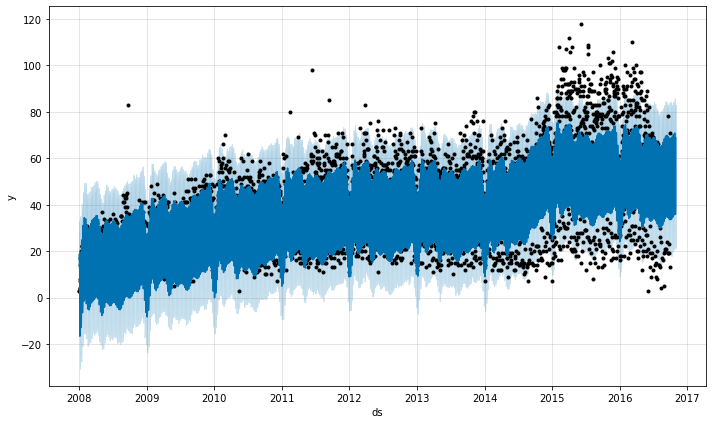

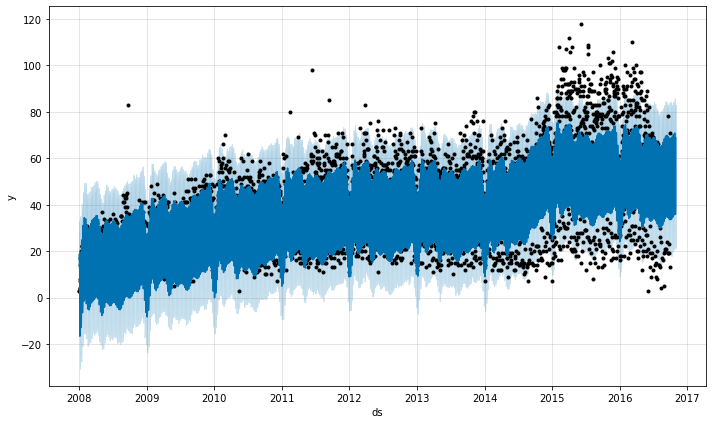

In [47]:
m.plot(forecast)

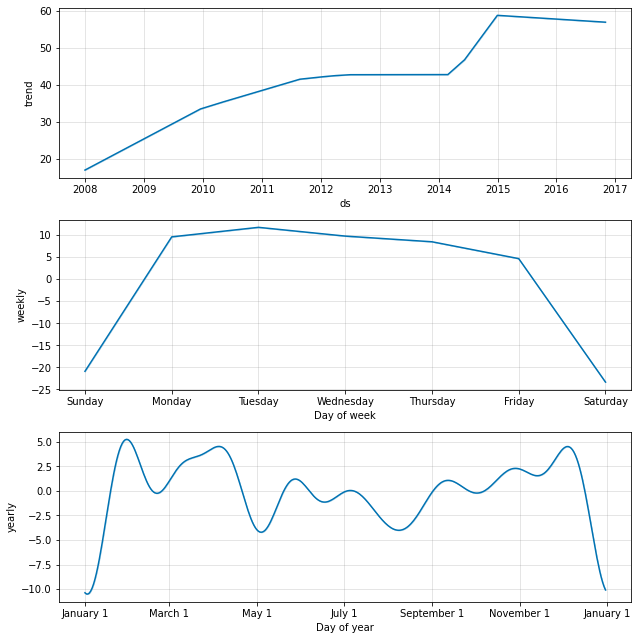

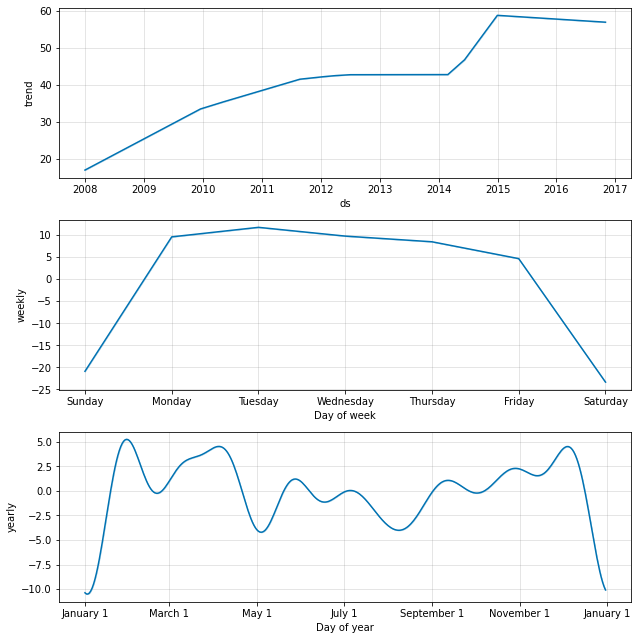

In [48]:
m.plot_components(forecast)

## Оценка качества Prophet

In [49]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [50]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(38.160405855822496, 10.85785875965312)

## Прогноз с BoxCox

In [51]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [52]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y']+1) # прибавляем единицу, так как в исходном ряде есть нули

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(28.826657518276125, 9.014803427443471)

## Визуализация результатов

In [53]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="darkorchid"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tozerox')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="darkorchid"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [54]:
show_forecast(cmp_df, predictions, 200)

##  Сравнение с ARIMA моделью

In [55]:
train_df = train_df.fillna(14).set_index('ds')

Критерий Дики-Фуллера: p=0.040320


<Figure size 1080x720 with 0 Axes>

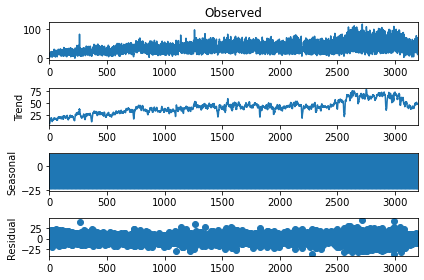

In [56]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [57]:
train_df.index = pd.to_datetime(train_df.index)

Оптимальный параметр преобразования Бокса-Кокса: 0.423912
Критерий Дики-Фуллера: p=0.040320


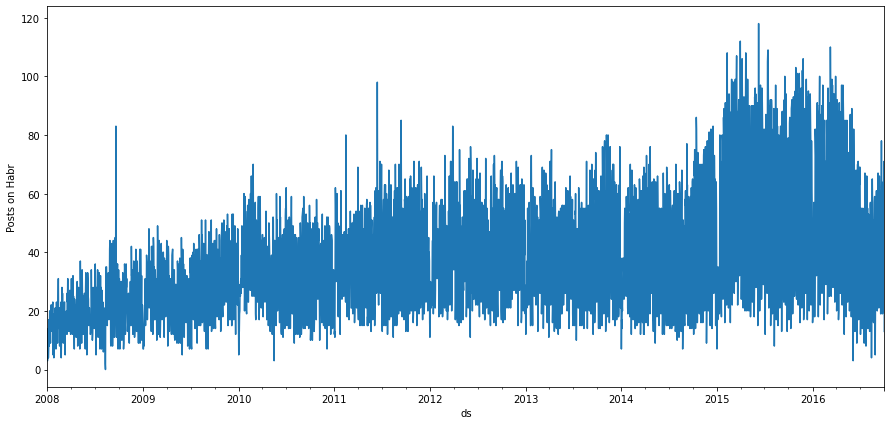

In [58]:
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
train_df.y.plot()
plt.ylabel(u'Posts on Habr')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

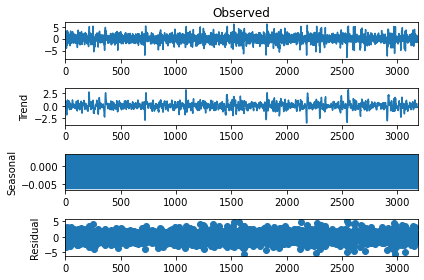

In [60]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

Начальные приближения Q = 1, q = 4, P = 5, p = 3

In [63]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

In [64]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

280

In [29]:
%%time
results = []
best_aic = float("inf")


for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        %time model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 109 ms, sys: 2.66 ms, total: 112 ms
Wall time: 200 ms
(0, 0, 0, 1)
CPU times: user 1.43 s, sys: 1.02 s, total: 2.45 s
Wall time: 1.49 s
(0, 0, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 496 ms, sys: 408 ms, total: 904 ms
Wall time: 563 ms
(0, 0, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.06 s, sys: 1.52 s, total: 3.58 s
Wall time: 1.97 s
(0, 0, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.04 s, sys: 815 ms, total: 1.85 s
Wall time: 997 ms
(0, 0, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.59 s, sys: 3.33 s, total: 7.92 s
Wall time: 4.08 s
(0, 0, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.62 s, sys: 1.99 s, total: 4.61 s
Wall time: 2.45 s
(0, 0, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.5 s, sys: 8.01 s, total: 19.5 s
Wall time: 10.1 s
(0, 0, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.84 s, sys: 3.37 s, total: 8.22 s
Wall time: 4.33 s
(0, 0, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 19.5 s, sys: 13.4 s, total: 32.9 s
Wall time: 17.1 s
(0, 0, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 7.52 s, sys: 5.22 s, total: 12.7 s
Wall time: 6.79 s
(0, 0, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 32.8 s, sys: 19.4 s, total: 52.1 s
Wall time: 28.6 s
(0, 0, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 10.1 s, sys: 6.42 s, total: 16.5 s
Wall time: 9.05 s
(0, 0, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 41.2 s, sys: 20.5 s, total: 1min 1s
Wall time: 39.4 s
(0, 1, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.76 s, sys: 1.15 s, total: 2.91 s
Wall time: 2.18 s
(0, 1, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.22 s, sys: 1.6 s, total: 3.82 s
Wall time: 1.97 s
(0, 1, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.11 s, sys: 752 ms, total: 1.86 s
Wall time: 958 ms
(0, 1, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.26 s, sys: 2.42 s, total: 5.68 s
Wall time: 2.9 s
(0, 1, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.74 s, sys: 1.96 s, total: 4.7 s
Wall time: 2.44 s
(0, 1, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 7.33 s, sys: 5.28 s, total: 12.6 s
Wall time: 6.42 s
(0, 1, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 5.03 s, sys: 3.55 s, total: 8.58 s
Wall time: 4.43 s
(0, 1, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 17.6 s, sys: 12.3 s, total: 29.9 s
Wall time: 15.4 s
(0, 1, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 9.11 s, sys: 6.44 s, total: 15.5 s
Wall time: 8 s
(0, 1, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 28.9 s, sys: 19.2 s, total: 48.1 s
Wall time: 25 s
(0, 1, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 14.8 s, sys: 10.1 s, total: 24.9 s
Wall time: 13.1 s
(0, 1, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 42.4 s, sys: 24.8 s, total: 1min 7s
Wall time: 37.1 s
(0, 1, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 19.3 s, sys: 12.2 s, total: 31.5 s
Wall time: 16.9 s
(0, 1, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 59.4 s, sys: 30.6 s, total: 1min 29s
Wall time: 52.4 s
(0, 2, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.09 s, sys: 2.99 s, total: 7.08 s
Wall time: 3.72 s
(0, 2, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.2 s, sys: 3.03 s, total: 7.22 s
Wall time: 3.83 s
(0, 2, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 6.99 s, sys: 5.09 s, total: 12.1 s
Wall time: 6.33 s
(0, 2, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.79 s, sys: 3.45 s, total: 8.24 s
Wall time: 4.23 s
(0, 2, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.61 s, sys: 3.26 s, total: 7.87 s
Wall time: 4.02 s
(0, 2, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 12 s, sys: 8.6 s, total: 20.6 s
Wall time: 10.5 s
(0, 2, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 6.26 s, sys: 4.48 s, total: 10.7 s
Wall time: 5.51 s
(0, 2, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 32.5 s, sys: 22.5 s, total: 55.1 s
Wall time: 28.3 s
(0, 2, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.1 s, sys: 7.79 s, total: 18.9 s
Wall time: 9.71 s
(0, 2, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 41.2 s, sys: 27.2 s, total: 1min 8s
Wall time: 36 s
(0, 2, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 19.1 s, sys: 13.2 s, total: 32.3 s
Wall time: 16.7 s
(0, 2, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 11s, sys: 39.2 s, total: 1min 50s
Wall time: 1min 3s
(0, 2, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 26.3 s, sys: 16.1 s, total: 42.4 s
Wall time: 24 s
(0, 2, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 26s, sys: 41.6 s, total: 2min 8s
Wall time: 1min 16s
(0, 3, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 6.87 s, sys: 4.9 s, total: 11.8 s
Wall time: 6.03 s
(0, 3, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 5.74 s, sys: 4.12 s, total: 9.86 s
Wall time: 5.01 s
(0, 3, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 16.3 s, sys: 11.5 s, total: 27.8 s
Wall time: 14.5 s
(0, 3, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 9.57 s, sys: 6.86 s, total: 16.4 s
Wall time: 8.7 s
(0, 3, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 26.3 s, sys: 18.4 s, total: 44.8 s
Wall time: 23.3 s
(0, 3, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 14.5 s, sys: 10.3 s, total: 24.7 s
Wall time: 12.6 s
(0, 3, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 47.9 s, sys: 30.4 s, total: 1min 18s
Wall time: 42.2 s
(0, 3, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 30.7 s, sys: 20.3 s, total: 51 s
Wall time: 30.4 s
(0, 3, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 12.6 s, sys: 8.84 s, total: 21.5 s
Wall time: 11 s
(0, 3, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 49 s, sys: 32.7 s, total: 1min 21s
Wall time: 42.7 s
(0, 3, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 22.8 s, sys: 15.7 s, total: 38.5 s
Wall time: 20 s
(0, 3, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 21s, sys: 45.9 s, total: 2min 7s
Wall time: 1min 13s
(0, 3, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 28.7 s, sys: 18.1 s, total: 46.8 s
Wall time: 25.1 s
(0, 3, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min, sys: 55.6 s, total: 2min 55s
Wall time: 1min 48s
(0, 4, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 7.96 s, sys: 5.89 s, total: 13.8 s
Wall time: 7.05 s
(0, 4, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.23 s, sys: 6.02 s, total: 14.2 s
Wall time: 7.26 s
(0, 4, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 19.2 s, sys: 13.7 s, total: 32.9 s
Wall time: 16.8 s
(0, 4, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 9.65 s, sys: 6.92 s, total: 16.6 s
Wall time: 8.47 s
(0, 4, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 34.2 s, sys: 24.3 s, total: 58.5 s
Wall time: 29.9 s
(0, 4, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 14.3 s, sys: 10.2 s, total: 24.5 s
Wall time: 12.5 s
(0, 4, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 45.5 s, sys: 28.3 s, total: 1min 13s
Wall time: 41.2 s
(0, 4, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 30.9 s, sys: 21.7 s, total: 52.5 s
Wall time: 27 s
(0, 4, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min, sys: 34 s, total: 1min 34s
Wall time: 53.8 s
(0, 4, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 49.3 s, sys: 33.3 s, total: 1min 22s
Wall time: 43.1 s
(0, 4, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 44s, sys: 45.9 s, total: 2min 30s
Wall time: 1min 36s
(0, 4, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 34s, sys: 52.3 s, total: 2min 26s
Wall time: 1min 24s
(0, 4, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 7s, sys: 51.4 s, total: 2min 58s
Wall time: 1min 53s
(0, 4, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 4s, sys: 1min, total: 3min 5s
Wall time: 1min 52s
(1, 0, 0, 0)
CPU times: user 129 ms, sys: 16.3 ms, total: 145 ms
Wall time: 146 ms
(1, 0, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.8 s, sys: 1.28 s, total: 3.08 s
Wall time: 1.58 s
(1, 0, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 875 ms, sys: 667 ms, total: 1.54 s
Wall time: 794 ms
(1, 0, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.45 s, sys: 1.78 s, total: 4.23 s
Wall time: 2.17 s
(1, 0, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.84 s, sys: 1.26 s, total: 3.11 s
Wall time: 1.6 s
(1, 0, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 6.22 s, sys: 4.42 s, total: 10.6 s
Wall time: 5.47 s
(1, 0, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.83 s, sys: 2.73 s, total: 6.56 s
Wall time: 3.4 s
(1, 0, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 13.6 s, sys: 9.39 s, total: 23 s
Wall time: 11.9 s
(1, 0, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 6.95 s, sys: 4.78 s, total: 11.7 s
Wall time: 6.08 s
(1, 0, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 26.2 s, sys: 17.6 s, total: 43.8 s
Wall time: 22.8 s
(1, 0, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 10.9 s, sys: 7.53 s, total: 18.5 s
Wall time: 9.62 s
(1, 0, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 40.3 s, sys: 25.1 s, total: 1min 5s
Wall time: 35.1 s
(1, 0, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 16.1 s, sys: 9.57 s, total: 25.7 s
Wall time: 14.3 s
(1, 0, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 4s, sys: 32.6 s, total: 1min 37s
Wall time: 56.8 s
(1, 1, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.05 s, sys: 2.27 s, total: 5.32 s
Wall time: 2.74 s
(1, 1, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.48 s, sys: 3.26 s, total: 7.74 s
Wall time: 3.93 s
(1, 1, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.2 s, sys: 7.93 s, total: 19.1 s
Wall time: 9.73 s
(1, 1, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 5.63 s, sys: 4.07 s, total: 9.7 s
Wall time: 4.92 s
(1, 1, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 24.3 s, sys: 16.9 s, total: 41.2 s
Wall time: 21.1 s
(1, 1, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.5 s, sys: 8.24 s, total: 19.8 s
Wall time: 10.1 s
(1, 1, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 41.4 s, sys: 25.2 s, total: 1min 6s
Wall time: 37.4 s
(1, 1, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 23.6 s, sys: 15.5 s, total: 39.1 s
Wall time: 24.1 s
(1, 1, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 15.7 s, sys: 11 s, total: 26.8 s
Wall time: 13.8 s
(1, 1, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 42.3 s, sys: 26.9 s, total: 1min 9s
Wall time: 36.8 s
(1, 1, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 20.2 s, sys: 14.1 s, total: 34.4 s
Wall time: 17.7 s
(1, 1, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 8s, sys: 39.6 s, total: 1min 48s
Wall time: 1min
(1, 1, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 29.4 s, sys: 17.5 s, total: 46.9 s
Wall time: 25.9 s
(1, 1, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 34s, sys: 41.9 s, total: 2min 16s
Wall time: 1min 24s
(1, 2, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 4.54 s, sys: 3.31 s, total: 7.85 s
Wall time: 3.99 s
(1, 2, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 9.36 s, sys: 6.8 s, total: 16.2 s
Wall time: 8.2 s
(1, 2, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.3 s, sys: 8.2 s, total: 19.5 s
Wall time: 9.88 s
(1, 2, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.8 s, sys: 8.56 s, total: 20.3 s
Wall time: 10.3 s
(1, 2, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 29.6 s, sys: 20.5 s, total: 50 s
Wall time: 26.7 s
(1, 2, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 21.1 s, sys: 14.7 s, total: 35.8 s
Wall time: 18.3 s
(1, 2, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 58.4 s, sys: 36.8 s, total: 1min 35s
Wall time: 51.5 s
(1, 2, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 44.3 s, sys: 31.2 s, total: 1min 15s
Wall time: 39.7 s
(1, 2, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 21s, sys: 44.8 s, total: 2min 5s
Wall time: 1min 11s
(1, 2, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 10s, sys: 45.8 s, total: 1min 56s
Wall time: 1min 1s
(1, 2, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 59s, sys: 55.8 s, total: 2min 55s
Wall time: 1min 49s
(1, 2, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 35s, sys: 53.3 s, total: 2min 28s
Wall time: 1min 25s
(1, 2, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 56s, sys: 1min 3s, total: 4min
Wall time: 2min 39s
(1, 2, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 35s, sys: 1min 7s, total: 3min 42s
Wall time: 2min 22s
(1, 3, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.27 s, sys: 5.96 s, total: 14.2 s
Wall time: 7.24 s
(1, 3, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 16.7 s, sys: 12 s, total: 28.7 s
Wall time: 14.6 s
(1, 3, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 18.7 s, sys: 13.5 s, total: 32.2 s
Wall time: 16.3 s
(1, 3, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 20.8 s, sys: 15 s, total: 35.8 s
Wall time: 18.2 s
(1, 3, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 43.7 s, sys: 30.5 s, total: 1min 14s
Wall time: 37.8 s
(1, 3, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 34.9 s, sys: 24.9 s, total: 59.9 s
Wall time: 30.5 s
(1, 3, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 23.8 s, sys: 17 s, total: 40.9 s
Wall time: 20.8 s
(1, 3, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 54.7 s, sys: 36.3 s, total: 1min 30s
Wall time: 51.8 s
(1, 3, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 48.3 s, sys: 34.3 s, total: 1min 22s
Wall time: 43 s
(1, 3, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 33s, sys: 59.1 s, total: 2min 33s
Wall time: 1min 23s
(1, 3, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 56.7 s, sys: 39.6 s, total: 1min 36s
Wall time: 49.4 s
(1, 3, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 58s, sys: 1min 7s, total: 3min 5s
Wall time: 1min 44s
(1, 3, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 13s, sys: 43.5 s, total: 1min 56s
Wall time: 1min 4s
(1, 3, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 11s, sys: 1min 22s, total: 4min 34s
Wall time: 2min 53s
(1, 4, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 16.4 s, sys: 11.6 s, total: 28 s
Wall time: 14.2 s
(1, 4, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 22.5 s, sys: 16.2 s, total: 38.6 s
Wall time: 19.7 s
(1, 4, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 13 s, sys: 9.2 s, total: 22.2 s
Wall time: 11.3 s
(1, 4, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 26 s, sys: 18.1 s, total: 44 s
Wall time: 26.4 s
(1, 4, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 31.4 s, sys: 22 s, total: 53.4 s
Wall time: 27.4 s
(1, 4, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 40.9 s, sys: 29.3 s, total: 1min 10s
Wall time: 35.7 s
(1, 4, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 46.1 s, sys: 28.1 s, total: 1min 14s
Wall time: 41.9 s
(1, 4, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 4s, sys: 45.3 s, total: 1min 49s
Wall time: 56.5 s
(1, 4, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 40s, sys: 57.8 s, total: 2min 37s
Wall time: 1min 28s
(1, 4, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 47s, sys: 1min 7s, total: 2min 54s
Wall time: 1min 33s
(1, 4, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 26s, sys: 1min 15s, total: 3min 42s
Wall time: 2min 12s
(1, 4, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 29s, sys: 1min 19s, total: 3min 49s
Wall time: 2min 15s
(1, 4, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 29s, sys: 1min 21s, total: 4min 51s
Wall time: 3min 11s
(1, 4, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 28s, sys: 1min 27s, total: 4min 56s
Wall time: 3min 9s
(2, 0, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 315 ms, sys: 274 ms, total: 589 ms
Wall time: 304 ms
(2, 0, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.64 s, sys: 1.91 s, total: 4.55 s
Wall time: 2.32 s
(2, 0, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.38 s, sys: 1.01 s, total: 2.4 s
Wall time: 1.23 s
(2, 0, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.21 s, sys: 2.34 s, total: 5.54 s
Wall time: 2.83 s
(2, 0, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2.36 s, sys: 1.71 s, total: 4.08 s
Wall time: 2.1 s
(2, 0, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.2 s, sys: 5.83 s, total: 14 s
Wall time: 7.16 s
(2, 0, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 5.04 s, sys: 3.51 s, total: 8.55 s
Wall time: 4.44 s
(2, 0, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 20 s, sys: 13.8 s, total: 33.7 s
Wall time: 17.6 s
(2, 0, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.46 s, sys: 5.94 s, total: 14.4 s
Wall time: 7.43 s
(2, 0, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 28 s, sys: 17 s, total: 45.1 s
Wall time: 28.6 s
(2, 0, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 14.3 s, sys: 9.42 s, total: 23.7 s
Wall time: 12.8 s
(2, 0, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 47.6 s, sys: 28.4 s, total: 1min 15s
Wall time: 41.4 s
(2, 0, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 17.5 s, sys: 10.7 s, total: 28.1 s
Wall time: 15.4 s
(2, 0, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 1s, sys: 31.5 s, total: 1min 32s
Wall time: 53.5 s
(2, 1, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 6.45 s, sys: 4.65 s, total: 11.1 s
Wall time: 5.64 s
(2, 1, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 5.88 s, sys: 4.23 s, total: 10.1 s
Wall time: 5.15 s
(2, 1, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 17 s, sys: 11.4 s, total: 28.4 s
Wall time: 18.5 s
(2, 1, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 7.27 s, sys: 5.25 s, total: 12.5 s
Wall time: 6.38 s
(2, 1, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 31.9 s, sys: 22.7 s, total: 54.6 s
Wall time: 28 s
(2, 1, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 15 s, sys: 10.7 s, total: 25.7 s
Wall time: 13.1 s
(2, 1, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 50.8 s, sys: 29.4 s, total: 1min 20s
Wall time: 45.3 s
(2, 1, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 33.4 s, sys: 23.1 s, total: 56.5 s
Wall time: 29.1 s
(2, 1, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 18s, sys: 37.9 s, total: 1min 56s
Wall time: 1min 12s
(2, 1, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 50.8 s, sys: 32.2 s, total: 1min 23s
Wall time: 44.2 s
(2, 1, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 47s, sys: 46.7 s, total: 2min 34s
Wall time: 1min 36s
(2, 1, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 13s, sys: 39.8 s, total: 1min 52s
Wall time: 1min 4s
(2, 1, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 59s, sys: 44.1 s, total: 2min 43s
Wall time: 1min 47s
(2, 1, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 45s, sys: 48.5 s, total: 2min 34s
Wall time: 1min 37s
(2, 2, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.76 s, sys: 6.21 s, total: 15 s
Wall time: 7.6 s
(2, 2, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 12.5 s, sys: 8.97 s, total: 21.5 s
Wall time: 10.9 s
(2, 2, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 24.4 s, sys: 17.5 s, total: 41.8 s
Wall time: 21.2 s
(2, 2, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 16.9 s, sys: 12 s, total: 29 s
Wall time: 14.7 s
(2, 2, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 45.9 s, sys: 32.5 s, total: 1min 18s
Wall time: 40.1 s
(2, 2, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 28.8 s, sys: 20.7 s, total: 49.5 s
Wall time: 25.2 s
(2, 2, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 12s, sys: 42.9 s, total: 1min 54s
Wall time: 1min 4s
(2, 2, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 53.4 s, sys: 36.5 s, total: 1min 29s
Wall time: 47.5 s
(2, 2, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min, sys: 59.3 s, total: 2min 59s
Wall time: 1min 48s
(2, 2, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 31s, sys: 58.4 s, total: 2min 29s
Wall time: 1min 20s
(2, 2, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 3s, sys: 43.2 s, total: 1min 47s
Wall time: 55.8 s
(2, 2, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 11s, sys: 1min 8s, total: 3min 19s
Wall time: 1min 58s
(2, 2, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 13s, sys: 42.8 s, total: 1min 55s
Wall time: 1min 7s
(2, 2, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 49s, sys: 1min 16s, total: 4min 5s
Wall time: 2min 32s
(2, 3, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 13.3 s, sys: 9.49 s, total: 22.8 s
Wall time: 11.6 s
(2, 3, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 17.9 s, sys: 12.6 s, total: 30.5 s
Wall time: 15.5 s
(2, 3, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 24.5 s, sys: 17.3 s, total: 41.8 s
Wall time: 22 s
(2, 3, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 26.9 s, sys: 19.4 s, total: 46.3 s
Wall time: 23.9 s
(2, 3, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 16.6 s, sys: 11.9 s, total: 28.5 s
Wall time: 14.5 s
(2, 3, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 39.3 s, sys: 28.1 s, total: 1min 7s
Wall time: 34.3 s
(2, 3, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 56.7 s, sys: 36.6 s, total: 1min 33s
Wall time: 50 s
(2, 3, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 12s, sys: 50.9 s, total: 2min 3s
Wall time: 1min 3s
(2, 3, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 24s, sys: 57.2 s, total: 2min 21s
Wall time: 1min 13s
(2, 3, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 43s, sys: 1min 4s, total: 2min 47s
Wall time: 1min 35s
(2, 3, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 33s, sys: 1min 16s, total: 3min 50s
Wall time: 2min 17s
(2, 3, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 29s, sys: 1min 18s, total: 3min 47s
Wall time: 2min 14s
(2, 3, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 16s, sys: 1min 20s, total: 3min 36s
Wall time: 2min 2s
(2, 3, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 5s, sys: 1min 23s, total: 4min 29s
Wall time: 2min 47s
(2, 4, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 13.3 s, sys: 9.36 s, total: 22.7 s
Wall time: 11.6 s
(2, 4, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 25.1 s, sys: 18 s, total: 43.1 s
Wall time: 22 s
(2, 4, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 31 s, sys: 21.2 s, total: 52.2 s
Wall time: 32.4 s
(2, 4, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 28.8 s, sys: 20.8 s, total: 49.5 s
Wall time: 25.3 s
(2, 4, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 43.5 s, sys: 30.6 s, total: 1min 14s
Wall time: 38.2 s
(2, 4, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 44.3 s, sys: 31.3 s, total: 1min 15s
Wall time: 38.6 s
(2, 4, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 32s, sys: 53.6 s, total: 2min 25s
Wall time: 1min 23s
(2, 4, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 28s, sys: 1min 1s, total: 2min 30s
Wall time: 1min 17s
(2, 4, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 25s, sys: 1min, total: 2min 25s
Wall time: 1min 17s
(2, 4, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 54s, sys: 1min 11s, total: 3min 6s
Wall time: 1min 41s
(2, 4, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 2s, sys: 41.4 s, total: 1min 43s
Wall time: 56.6 s
(2, 4, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 44s, sys: 1min 23s, total: 4min 8s
Wall time: 2min 30s
(2, 4, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 53s, sys: 1min 33s, total: 4min 27s
Wall time: 2min 33s
(2, 4, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 26s, sys: 1min 31s, total: 4min 58s
Wall time: 3min 9s
(3, 0, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 465 ms, sys: 352 ms, total: 817 ms
Wall time: 427 ms
(3, 0, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.39 s, sys: 2.36 s, total: 5.75 s
Wall time: 2.94 s
(3, 0, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1.74 s, sys: 1.25 s, total: 2.99 s
Wall time: 1.53 s
(3, 0, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.91 s, sys: 2.81 s, total: 6.71 s
Wall time: 3.42 s
(3, 0, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3.12 s, sys: 2.26 s, total: 5.38 s
Wall time: 2.8 s
(3, 0, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 9.54 s, sys: 6.75 s, total: 16.3 s
Wall time: 8.37 s
(3, 0, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 5.61 s, sys: 3.97 s, total: 9.59 s
Wall time: 4.95 s
(3, 0, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 18.5 s, sys: 12.6 s, total: 31 s
Wall time: 16.1 s
(3, 0, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11 s, sys: 7.62 s, total: 18.6 s
Wall time: 9.6 s
(3, 0, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 34 s, sys: 21.8 s, total: 55.8 s
Wall time: 29.5 s
(3, 0, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 15 s, sys: 10 s, total: 25 s
Wall time: 13.1 s
(3, 0, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 54.5 s, sys: 31.3 s, total: 1min 25s
Wall time: 47.9 s
(3, 0, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 20.5 s, sys: 11.7 s, total: 32.2 s
Wall time: 18.2 s
(3, 0, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 17s, sys: 35.5 s, total: 1min 52s
Wall time: 1min 9s
(3, 1, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.47 s, sys: 5.97 s, total: 14.4 s
Wall time: 7.34 s
(3, 1, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 8.58 s, sys: 6.04 s, total: 14.6 s
Wall time: 7.48 s
(3, 1, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 18 s, sys: 12.7 s, total: 30.7 s
Wall time: 15.7 s
(3, 1, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 9.78 s, sys: 7.17 s, total: 16.9 s
Wall time: 8.64 s
(3, 1, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 36 s, sys: 24.8 s, total: 1min
Wall time: 32 s
(3, 1, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 24 s, sys: 17 s, total: 41.1 s
Wall time: 21.9 s
(3, 1, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 59 s, sys: 35.4 s, total: 1min 34s
Wall time: 52.5 s
(3, 1, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 31.6 s, sys: 21.8 s, total: 53.4 s
Wall time: 27.6 s
(3, 1, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 29s, sys: 1min 6s, total: 3min 36s
Wall time: 2min 16s
(3, 1, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 55.9 s, sys: 33.8 s, total: 1min 29s
Wall time: 48.8 s
(3, 1, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 34s, sys: 59.7 s, total: 3min 34s
Wall time: 2min 23s
(3, 1, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 23s, sys: 44.9 s, total: 2min 8s
Wall time: 1min 14s
(3, 1, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 54s, sys: 53.6 s, total: 3min 47s
Wall time: 2min 42s
(3, 1, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 7s, sys: 54.1 s, total: 3min 1s
Wall time: 1min 57s
(3, 2, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 11.7 s, sys: 8.22 s, total: 19.9 s
Wall time: 10.2 s
(3, 2, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 19.1 s, sys: 13.7 s, total: 32.8 s
Wall time: 16.8 s
(3, 2, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 16.6 s, sys: 11.7 s, total: 28.3 s
Wall time: 14.5 s
(3, 2, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 23.7 s, sys: 17 s, total: 40.7 s
Wall time: 20.9 s
(3, 2, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 30.5 s, sys: 21.2 s, total: 51.7 s
Wall time: 26.8 s
(3, 2, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 45.5 s, sys: 32.4 s, total: 1min 17s
Wall time: 39.9 s
(3, 2, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 18s, sys: 45 s, total: 2min 3s
Wall time: 1min 12s
(3, 2, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 7s, sys: 47.6 s, total: 1min 55s
Wall time: 59.3 s
(3, 2, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 45s, sys: 46.2 s, total: 2min 32s
Wall time: 1min 38s
(3, 2, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 1min 17s, sys: 47.3 s, total: 2min 4s
Wall time: 1min 8s
(3, 2, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 51s, sys: 1min 4s, total: 3min 56s
Wall time: 2min 39s
(3, 2, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 27s, sys: 1min 16s, total: 3min 43s
Wall time: 2min 11s
(3, 2, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 3min 18s, sys: 1min 1s, total: 4min 19s
Wall time: 3min 1s
(3, 2, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 39s, sys: 1min, total: 3min 39s
Wall time: 2min 26s
(3, 3, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 15.3 s, sys: 10.8 s, total: 26.1 s
Wall time: 13.4 s
(3, 3, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 29.9 s, sys: 21.3 s, total: 51.2 s
Wall time: 26.1 s
(3, 3, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 30.1 s, sys: 21.3 s, total: 51.4 s
Wall time: 26.3 s
(3, 3, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 32.9 s, sys: 23.5 s, total: 56.4 s
Wall time: 28.8 s
(3, 3, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 57.7 s, sys: 39 s, total: 1min 36s
Wall time: 54.8 s
(3, 3, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 49.2 s, sys: 34.7 s, total: 1min 23s
Wall time: 43.7 s
(3, 3, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 34s, sys: 56.4 s, total: 2min 31s
Wall time: 1min 24s
(3, 3, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 21s, sys: 56.9 s, total: 2min 18s
Wall time: 1min 11s
(3, 3, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 3s, sys: 1min 13s, total: 3min 17s
Wall time: 1min 49s
(3, 3, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 58s, sys: 1min 8s, total: 3min 7s
Wall time: 1min 47s
(3, 3, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 44s, sys: 1min 12s, total: 2min 57s
Wall time: 1min 31s
(3, 3, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 9s, sys: 1min 6s, total: 3min 16s
Wall time: 2min 1s
(3, 3, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 2min 1s, sys: 1min 9s, total: 3min 10s
Wall time: 1min 48s
(3, 3, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4min, sys: 1min 32s, total: 5min 32s
Wall time: 3min 45s
(3, 4, 0, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



CPU times: user 17.8 s, sys: 12 s, total: 29.8 s
Wall time: 19.1 s
(3, 4, 0, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 25.7 s, sys: 18.2 s, total: 43.8 s
Wall time: 22.3 s
(3, 4, 1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 39 s, sys: 28.1 s, total: 1min 7s
Wall time: 34.2 s
(3, 4, 1, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 32.3 s, sys: 23.1 s, total: 55.4 s
Wall time: 28.2 s
(3, 4, 2, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 52.6 s, sys: 37 s, total: 1min 29s
Wall time: 46 s
(3, 4, 2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 53.6 s, sys: 37.7 s, total: 1min 31s
Wall time: 46.6 s
(3, 4, 3, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 22s, sys: 53.4 s, total: 2min 15s
Wall time: 1min 12s
(3, 4, 3, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1min 30s, sys: 1min 2s, total: 2min 33s
Wall time: 1min 21s
(3, 4, 4, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 20s, sys: 1min 14s, total: 3min 34s
Wall time: 2min 5s
(3, 4, 4, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 16s, sys: 1min 19s, total: 3min 36s
Wall time: 2min 1s
(3, 4, 5, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 6s, sys: 1min 32s, total: 4min 38s
Wall time: 2min 51s
(3, 4, 5, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 55s, sys: 1min 29s, total: 4min 24s
Wall time: 2min 37s
(3, 4, 6, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 4min 10s, sys: 1min 33s, total: 5min 44s
Wall time: 3min 46s
(3, 4, 6, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 3min 52s, sys: 1min 32s, total: 5min 24s
Wall time: 3min 34s
CPU times: user 4h 2min 28s, sys: 2h 13min 20s, total: 6h 15min 49s
Wall time: 3h 37min 50s


In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
129  (1, 4, 1, 1)  9783.386711
269  (3, 4, 1, 1)  9784.026427
131  (1, 4, 2, 1)  9784.832131
271  (3, 4, 2, 1)  9785.569190
133  (1, 4, 3, 1)  9786.291142


In [31]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                 3197
Model:             SARIMAX(1, 1, 4)x(1, 1, 1, 7)   Log Likelihood               -4883.693
Date:                           Sat, 12 Sep 2020   AIC                           9783.387
Time:                                   14:28:20   BIC                           9831.926
Sample:                               01-01-2008   HQIC                          9800.792
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8729      0.034     25.557      0.000       0.806       0.940
ma.L1         -1.6060      0.036    -44.355

Критерий Стьюдента: p=0.045993
Критерий Дики-Фуллера: p=0.000000


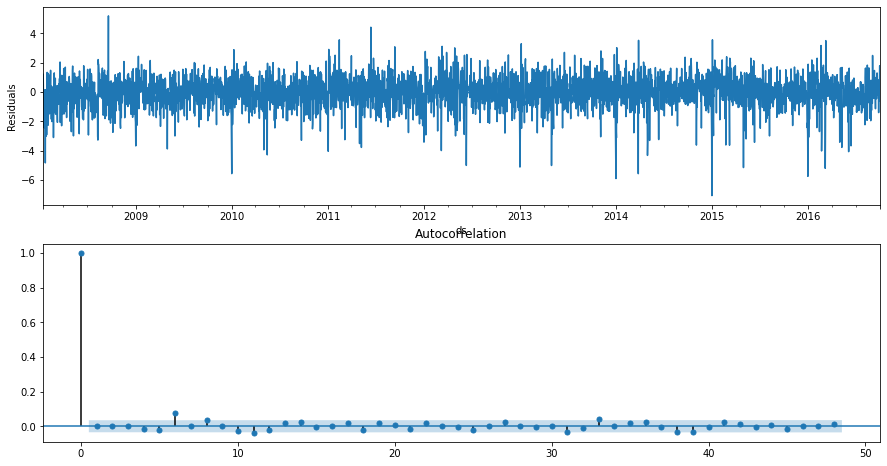

In [32]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

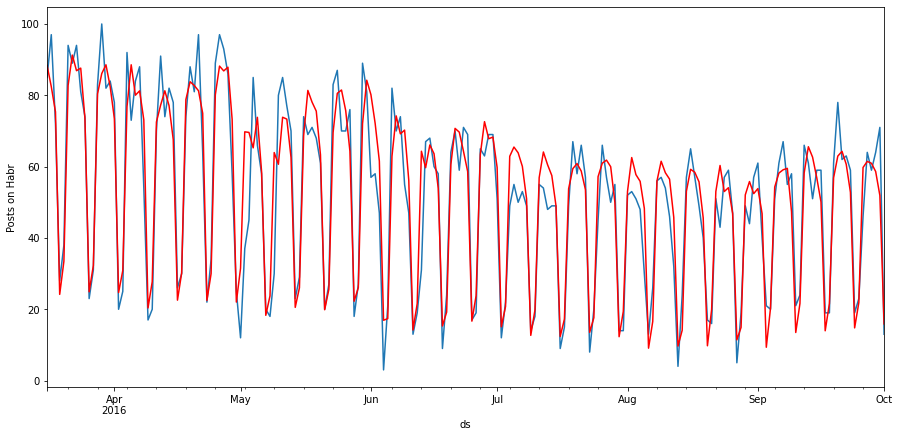

In [33]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('Posts on Habr');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



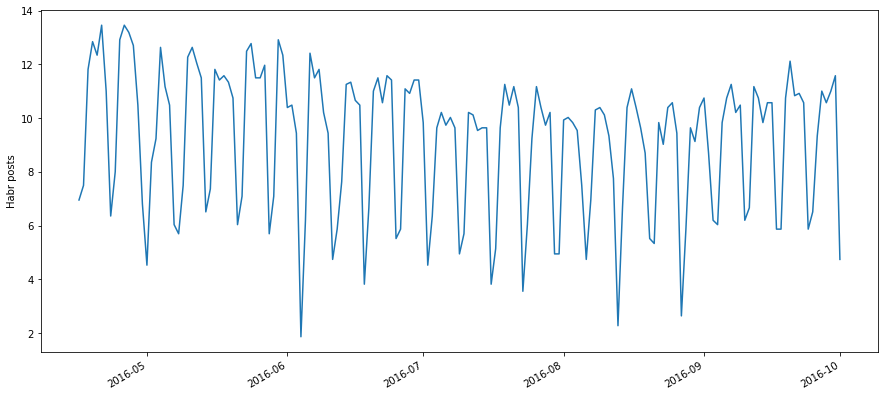

In [34]:
arima_df = train_df2.set_index('ds')[['y']]

date_list = [pd.datetime.strptime("2016-10-01", "%Y-%m-%d") + 
             pd.Timedelta(x) for x in range(0, predictions+1)]
future = pd.DataFrame(index=date_list, columns= arima_df.columns)
arima_df = pd.concat([arima_df, future])
arima_df['forecast'] = invboxcox(best_model.predict(start=train_df.shape[0], end=train_df.shape[0]+predictions-1), lmbda)
plt.figure(figsize=(15,7))
arima_df.y.tail(200).plot()
arima_df.forecast.tail(200).plot(color='r')
plt.ylabel('Habr posts');

In [35]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2008-01-01,18.524116,4.086451,33.498854,3,-15.524116,-517.470536
2008-01-02,16.365934,1.456771,31.885729,3,-13.365934,-445.531117
2008-01-03,15.010342,0.436377,29.400471,4,-11.010342,-275.258552
2008-01-04,11.227557,-2.664516,26.894319,14,2.772443,19.803168
2008-01-05,-16.609659,-31.356235,-2.002054,4,20.609659,515.241486


In [36]:
cmp_df = cmp_df.join(arima_df[['forecast']])

In [37]:
import numpy as np
cmp_df['e_arima'] = cmp_df['y'] - cmp_df['forecast']
cmp_df['p_arima'] = 100*cmp_df['e_arima']/cmp_df['y']

In [38]:
num_values = 200

forecast = go.Scatter(
    name='Prophet',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).yhat,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
)


fact = go.Scatter(
    name='Fact',
    x=cmp_df.tail(num_values).index,
    y=cmp_df.tail(num_values).y,
    marker=dict(color="red"),
    mode='lines',
)

arima = go.Scatter(
    name='ARIMA',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).forecast,
    mode='lines'
)

# Trace order can be important
# with continuous error bars
data = [forecast, fact, arima]

layout = go.Layout(
    yaxis=dict(title='Посты'),
    title='Опубликованные посты на Хабрахабре',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)